## Librairies + importation

In [1]:
import sys
sys.path.append('C:\\Users\\l.boisson\\AppData\\Local\\mambaforge\\lib\\site-packages')

from pathlib import Path
from scipy import signal, fftpack, fft, integrate
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
from seaborn import axes_style
import pandas as pd
import xarray as xr
import feather
import csv
import re
import matplotlib as mpl
import os
from scipy.signal import butter, filtfilt
from scipy.stats import chi2
from matplotlib.patches import Ellipse
from itertools import chain, product, pairwise
from more_itertools import consecutive_groups
import tkinter as tk
from tkinter import filedialog
from scipy.interpolate import interp1d

# Data_Path = Path(
#     "C:\\Users\\l.boisson\\Documents\\LPG\\Manips"
# )

sns.set_theme()
sns.set_style("white")

In [2]:
# crée une instance GUI
root = tk.Tk()
root.withdraw()  # Hide the main window

# Ask user to select the data folder using a file explorer dialog
# Check if data_folder_path is already loaded in Jupyter variables
try:
    data_folder_path
except NameError:
    data_folder_path = None

if data_folder_path is None:
    root = tk.Tk()
    root.withdraw()  # Hide the main window

    # Open file explorer dialog to select the data folder
    data_folder_path = filedialog.askdirectory(title="Select Data Folder")

    if not data_folder_path:
        print("No folder selected. Exiting.")
        exit()
Data_Path = Path(data_folder_path)

path_export = Data_Path.as_posix() + '/Exports/'
if not os.path.exists(path_export):
    os.makedirs(path_export)

## Définition des fonctions

In [26]:
def extract_file_info(file_path):
    match_participant = re.search(r"(\d{3})", file_path)
    participant = match_participant.group() if match_participant else None
    
    match_condition = re.search(r"(CH|H|CTRL)", file_path)
    condition = match_condition.group() if match_condition else None
    
    match_contraction = re.search(r"(CON60|EXC|ISO)", file_path)
    contraction = match_contraction.group() if match_contraction else None
    
    match_essai = re.search(r"_(\d{1})_", file_path)
    essai = match_essai.group(1) if match_essai else None
    
    if contraction == 'EXC':
        match_essai = re.search(r"(?<=_)\w{1,2}(?=.cxp)", file_path)
        essai = match_essai.group() if match_essai else None
        mesure = 0
    
    else:
        match_mesure = re.search(r"(?<=_)\w{2}(?=.cxp)", file_path)
        mesure = match_mesure.group() if match_mesure else None
        
    return {
        "participant": participant,
        "condition": condition,
        "contraction": contraction,
        "essai": essai,
        "mesure": mesure
    }

def apply_calcul_repetitions(group):
    if (group['participant'].iloc[0] == '005') & (group['contraction'].iloc[0] == 'CON60') & (group['condition'].iloc[0] == 'CTRL') & (group['mesure'].iloc[0] == '01'):
        force_threshold = 41
        min_consecutive = 4
    
    elif (group['participant'].iloc[0] == '003') & (group['contraction'].iloc[0] == 'ISO') & (group['condition'].iloc[0] == 'CH') & (group['mesure'].iloc[0] == '11') & (group['essai'].iloc[0] == '2'):
        force_threshold = 30
        min_consecutive = 4
        
    else:
        force_threshold = 25
        min_consecutive = 4

    return calcul_repetitions(group, force_threshold, min_consecutive)

def calcul_repetitions(df, force_threshold=25, min_consecutive=4):
    df = df.copy()

    df.loc[df.Force < force_threshold, 'mouvement'] = 'Extension'
    df.loc[df.Force >= force_threshold, 'mouvement'] = 'Flexion'

    df['repetition'] = 0

    threshold_down = False
    repetition = 0

    i = 0
    while i < len(df):
        
        # if (df.participant == '005') & (df.contraction == 'CON60') & (df.condition == 'CTRL') & (df.mesure == '01'):
        #     force_threshold = 30
        #     min_consecutive = 4
        
        if df.loc[df.index[i], 'Force'] >= force_threshold and not threshold_down:
            if i + min_consecutive <= len(df) and all(df.loc[df.index[i:i+min_consecutive], 'Force'] >= force_threshold):
                repetition += 1
                threshold_down = True
                i += min_consecutive - 1
            else:
                threshold_down = False
        elif df.loc[df.index[i], 'Force'] < force_threshold:
            threshold_down = False
        df.loc[df.index[i], 'repetition'] = repetition
        i += 1

    return df

def reset_time(df):
    print(df.name)
    df.Time -= df.Time.values[0]
    return df

def resample_phase(df):
    # Calculate the step duration
    try:
        # Calculate the resampling frequency
        resampling = np.linspace(
            df["Time"].iloc[0], df["Time"].iloc[-1], num=100, endpoint = True
        )

        # Resample the data for this step using interpolation
        interp_data = df.drop("Time", axis=1).apply(
            lambda col: interp1d(df["Time"], col)(resampling)
        ).rename_axis('Cycle_%')

    except IndexError:
        print(f"Error encountered in {df.index.unique()}. Skipping this group...")
        return pd.DataFrame()
    
    return interp_data

## Extraction données data

In [77]:
df_column = pd.DataFrame()

for filename in Data_Path.glob("Manips_test/*.cxp"):
    print(filename)
    file_path = filename.as_posix()
    file_info = extract_file_info(filename.name)
    
    if file_info is not None:
        contraction_type = file_info["contraction"]
        if contraction_type in ["ISO"]:
            skiprows = 151
        else:
            skiprows = 210
        
        data = pd.read_table(
            file_path,
            on_bad_lines='skip',
            encoding='latin-1',
            skiprows=skiprows,
            names=["Force", "Vitesse", "Angle"],
            header=0
        )
        
        data = data.assign(**file_info)
        
        df_column = pd.concat([df_column, data])

df_column['Frame'] = df_column.groupby(["participant", "condition", "contraction", "essai", "mesure"]).cumcount() + 1

df_column['Time'] = df_column['Frame'] / 256
df_column['Vitesse'] = df_column['Vitesse']
df_column['Angle'] = df_column['Angle']

df_column = df_column.reset_index(drop=True)

# Suppression de la fin d'un signal comportant des pics inutiles
df_column = df_column[~((df_column['participant'] == '003') & 
          (df_column['contraction'] == 'ISO') & 
          (df_column['condition'] == 'CH') & 
          (df_column['mesure'] == '11') & 
          (df_column['essai'] == '2') &
          (df_column['Time'] >= 17))]

df_column = df_column[~((df_column['participant'] == '005') & 
          (df_column['contraction'] == 'ISO') & 
          (df_column['condition'] == 'H') & 
          (df_column['mesure'] == '11') & 
          (df_column['essai'] == '2') &
          (df_column['Time'] >= 14.3))]

df_column = df_column[~((df_column['participant'] == '005') & 
          (df_column['contraction'] == 'ISO') & 
          (df_column['condition'] == 'H') & 
          (df_column['mesure'] == '01') & 
          (df_column['essai'] == '2') &
          (df_column['Time'] >= 14.7))]

df_column = df_column[~((df_column['participant'] == '007') & 
          (df_column['contraction'] == 'ISO') & 
          (df_column['condition'] == 'CTRL') & 
          (df_column['mesure'] == '01') & 
          (df_column['essai'] == '1') &
          (df_column['Time'] <= 7))]

df_column

C:\Users\l.boisson\Documents\1- Projets traitement\ActivGun\Manips_test\001_CH_ISO_1_01.cxp
C:\Users\l.boisson\Documents\1- Projets traitement\ActivGun\Manips_test\001_CH_ISO_1_02.cxp
C:\Users\l.boisson\Documents\1- Projets traitement\ActivGun\Manips_test\001_CH_ISO_1_11.cxp
C:\Users\l.boisson\Documents\1- Projets traitement\ActivGun\Manips_test\001_CH_ISO_1_21.cxp
C:\Users\l.boisson\Documents\1- Projets traitement\ActivGun\Manips_test\001_CH_ISO_2_01.cxp
C:\Users\l.boisson\Documents\1- Projets traitement\ActivGun\Manips_test\001_CH_ISO_2_02.cxp
C:\Users\l.boisson\Documents\1- Projets traitement\ActivGun\Manips_test\001_CH_ISO_2_11.cxp
C:\Users\l.boisson\Documents\1- Projets traitement\ActivGun\Manips_test\001_CH_ISO_2_21.cxp
C:\Users\l.boisson\Documents\1- Projets traitement\ActivGun\Manips_test\001_CTRL_ISO_1_01.cxp
C:\Users\l.boisson\Documents\1- Projets traitement\ActivGun\Manips_test\001_CTRL_ISO_1_02.cxp
C:\Users\l.boisson\Documents\1- Projets traitement\ActivGun\Manips_test\001_

,Force,Vitesse,Angle,participant,condition,contraction,essai,mesure,Frame,Time
0,0.497,-3.515,-89.780,001,CH,ISO,1,01,1,0.003906
1,0.253,-3.124,-89.793,001,CH,ISO,1,01,2,0.007812
2,0.253,-1.953,-89.800,001,CH,ISO,1,01,3,0.011719
3,-0.235,-1.562,-89.806,001,CH,ISO,1,01,4,0.015625
4,0.009,-2.343,-89.815,001,CH,ISO,1,01,5,0.019531
...,...,...,...,...,...,...,...,...,...,...
623448,2.235,0.000,-90.136,008,CTRL,ISO,2,21,3875,15.136719
623449,1.503,0.000,-90.136,008,CTRL,ISO,2,21,3876,15.140625
623450,2.235,0.000,-90.136,008,CTRL,ISO,2,21,3877,15.144531
623451,1.991,0.000,-90.136,008,CTRL,ISO,2,21,3878,15.148438


## Répétitions

In [78]:
df_force_phase = df_column.groupby(['participant', 'condition', 'contraction', 'essai', 'mesure']).apply(apply_calcul_repetitions).reset_index(drop=True)

df_force_phase

C:\Users\l.boisson\AppData\Local\Temp\ipykernel_1152\4081805852.py:18: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_force_phase = df_column.groupby(['participant', 'condition', 'contraction', 'essai', 'mesure']).apply(apply_calcul_repetitions).reset_index(drop=True)


,Force,Vitesse,Angle,participant,condition,contraction,essai,mesure,Frame,Time,mouvement,repetition
0,0.497,-3.515,-89.780,001,CH,ISO,1,01,1,0.003906,Extension,0
1,0.253,-3.124,-89.793,001,CH,ISO,1,01,2,0.007812,Extension,0
2,0.253,-1.953,-89.800,001,CH,ISO,1,01,3,0.011719,Extension,0
3,-0.235,-1.562,-89.806,001,CH,ISO,1,01,4,0.015625,Extension,0
4,0.009,-2.343,-89.815,001,CH,ISO,1,01,5,0.019531,Extension,0
...,...,...,...,...,...,...,...,...,...,...,...,...
608390,2.235,0.000,-90.136,008,CTRL,ISO,2,21,3875,15.136719,Extension,1
608391,1.503,0.000,-90.136,008,CTRL,ISO,2,21,3876,15.140625,Extension,1
608392,2.235,0.000,-90.136,008,CTRL,ISO,2,21,3877,15.144531,Extension,1
608393,1.991,0.000,-90.136,008,CTRL,ISO,2,21,3878,15.148438,Extension,1


## Reset time

In [79]:
df_force_phase = df_force_phase.groupby(['participant','condition','contraction','essai', 'mesure', 'mouvement', 'repetition'], group_keys=False).apply(reset_time)
df_force_phase

('001', 'CH', 'ISO', '1', '01', 'Extension', 0)
('001', 'CH', 'ISO', '1', '01', 'Extension', 1)
('001', 'CH', 'ISO', '1', '01', 'Flexion', 0)
('001', 'CH', 'ISO', '1', '01', 'Flexion', 1)
('001', 'CH', 'ISO', '1', '02', 'Extension', 0)
('001', 'CH', 'ISO', '1', '02', 'Extension', 1)
('001', 'CH', 'ISO', '1', '02', 'Flexion', 0)
('001', 'CH', 'ISO', '1', '02', 'Flexion', 1)
('001', 'CH', 'ISO', '1', '11', 'Extension', 0)
('001', 'CH', 'ISO', '1', '11', 'Extension', 1)
('001', 'CH', 'ISO', '1', '11', 'Flexion', 0)
('001', 'CH', 'ISO', '1', '11', 'Flexion', 1)
('001', 'CH', 'ISO', '1', '21', 'Extension', 0)
('001', 'CH', 'ISO', '1', '21', 'Extension', 1)
('001', 'CH', 'ISO', '1', '21', 'Flexion', 0)
('001', 'CH', 'ISO', '1', '21', 'Flexion', 1)
('001', 'CH', 'ISO', '2', '01', 'Extension', 0)
('001', 'CH', 'ISO', '2', '01', 'Extension', 1)
('001', 'CH', 'ISO', '2', '01', 'Flexion', 0)
('001', 'CH', 'ISO', '2', '01', 'Flexion', 1)
('001', 'CH', 'ISO', '2', '02', 'Extension', 0)
('001', 'CH'

,Force,Vitesse,Angle,participant,condition,contraction,essai,mesure,Frame,Time,mouvement,repetition
0,0.497,-3.515,-89.780,001,CH,ISO,1,01,1,0.000000,Extension,0
1,0.253,-3.124,-89.793,001,CH,ISO,1,01,2,0.003906,Extension,0
2,0.253,-1.953,-89.800,001,CH,ISO,1,01,3,0.007812,Extension,0
3,-0.235,-1.562,-89.806,001,CH,ISO,1,01,4,0.011719,Extension,0
4,0.009,-2.343,-89.815,001,CH,ISO,1,01,5,0.015625,Extension,0
...,...,...,...,...,...,...,...,...,...,...,...,...
608390,2.235,0.000,-90.136,008,CTRL,ISO,2,21,3875,0.429688,Extension,1
608391,1.503,0.000,-90.136,008,CTRL,ISO,2,21,3876,0.433594,Extension,1
608392,2.235,0.000,-90.136,008,CTRL,ISO,2,21,3877,0.437500,Extension,1
608393,1.991,0.000,-90.136,008,CTRL,ISO,2,21,3878,0.441406,Extension,1


## Resample

In [80]:
df_flexion = df_force_phase[df_force_phase['mouvement'] == 'Flexion']
df_flexion.reset_index()
df_flexion.set_index(['participant','condition','contraction','essai', 'mesure', 'mouvement', 'repetition'], inplace = True)
df_flexion_interpol = df_flexion.groupby(['participant','condition','contraction','essai', 'mesure', 'mouvement', 'repetition']).apply(resample_phase)
df_flexion_interpol.reset_index(inplace=True)

df_flexion_interpol

,participant,condition,contraction,essai,mesure,mouvement,repetition,Cycle_%,Force,Vitesse,Angle,Frame
0,001,CH,ISO,1,01,Flexion,0,0,27.814000,0.391000,-90.134000,2305.000000
1,001,CH,ISO,1,01,Flexion,0,1,27.912646,0.383101,-90.134000,2305.020202
2,001,CH,ISO,1,01,Flexion,0,2,28.011293,0.375202,-90.134000,2305.040404
3,001,CH,ISO,1,01,Flexion,0,3,28.109939,0.367303,-90.134000,2305.060606
4,001,CH,ISO,1,01,Flexion,0,4,28.208586,0.359404,-90.134000,2305.080808
...,...,...,...,...,...,...,...,...,...,...,...,...
29695,008,CTRL,ISO,2,21,Flexion,1,95,220.469778,-0.173778,-90.111000,3707.555556
29696,008,CTRL,ISO,2,21,Flexion,1,96,176.145000,0.000000,-90.111000,3721.666667
29697,008,CTRL,ISO,2,21,Flexion,1,97,112.424000,-0.304111,-90.116778,3735.777778
29698,008,CTRL,ISO,2,21,Flexion,1,98,59.825222,0.000000,-90.125000,3749.888889


# Contraction concentrique

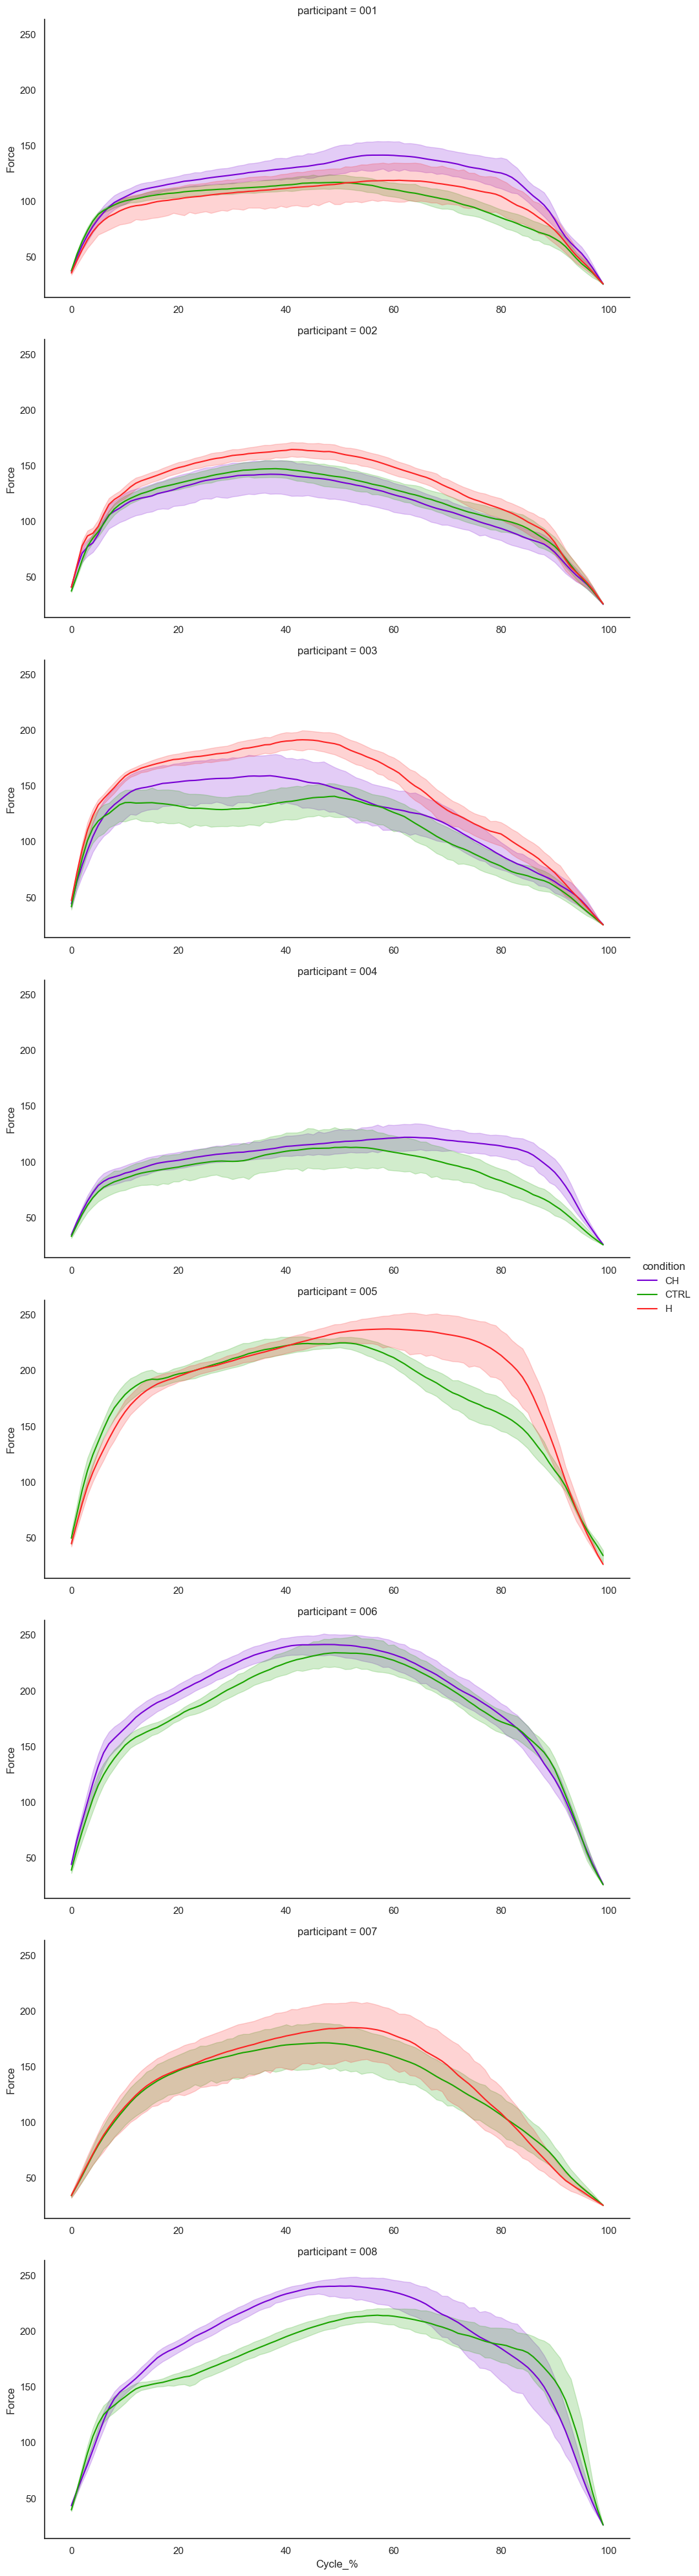

In [376]:
data_plot = df_flexion_interpol[
    (df_flexion_interpol['repetition'] != 0)
    & (df_flexion_interpol['mouvement'] == 'Flexion')
]

palette_colors = {'CTRL': '#1BA400', 'H': '#FC2424', 'CH': '#7700D4'}

sns.relplot(data_plot, 
             x= 'Cycle_%',
             y = 'Force',
             hue= 'condition',
             kind = 'line',
             aspect= 2,
             row = 'participant',
             palette=palette_colors,
             facet_kws=dict(sharex=False)
             )

# Contraction excentrique

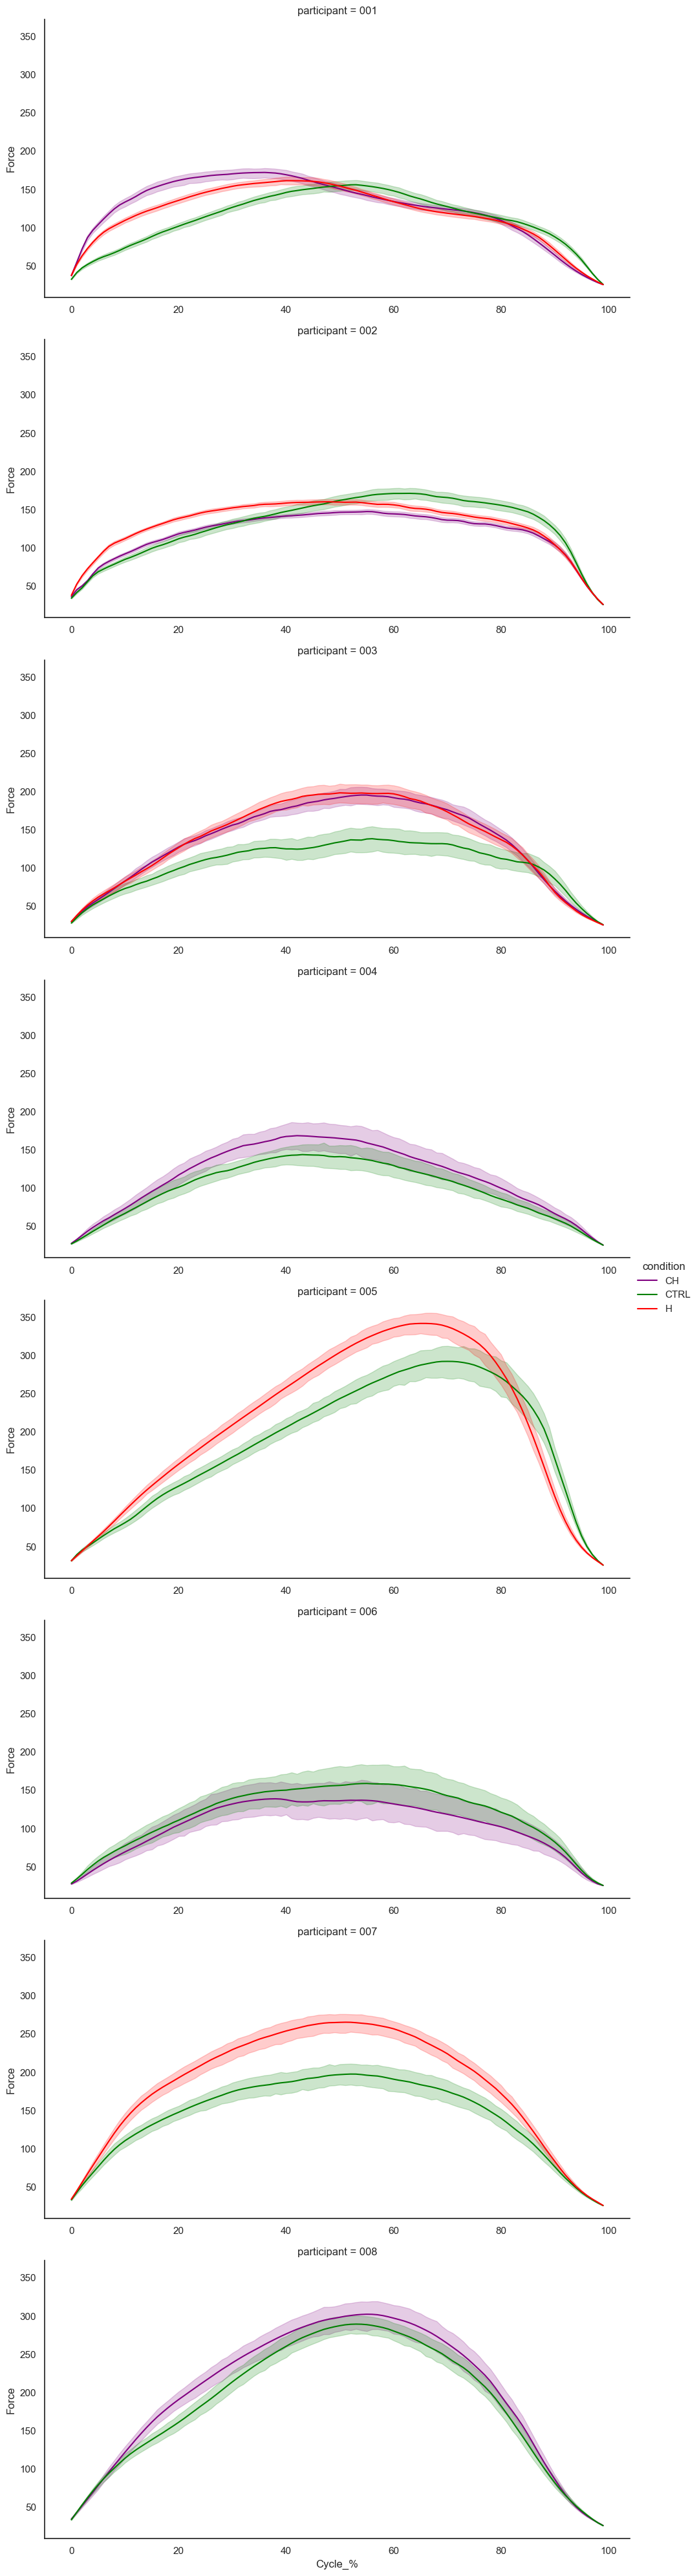

In [309]:
data_plot = df_flexion_interpol[
    (df_flexion_interpol['repetition'] != 0)
    & (df_flexion_interpol['mouvement'] == 'Flexion')
]

palette_colors = {'CTRL': 'green', 'H': 'red', 'CH': 'purple'}

sns.relplot(data_plot, 
             x= 'Cycle_%',
             y = 'Force',
             hue= 'condition',
             kind = 'line',
             aspect= 2,
             row = 'participant',
             palette=palette_colors,
             facet_kws=dict(sharex=False)
             )


# Contraction isométrique

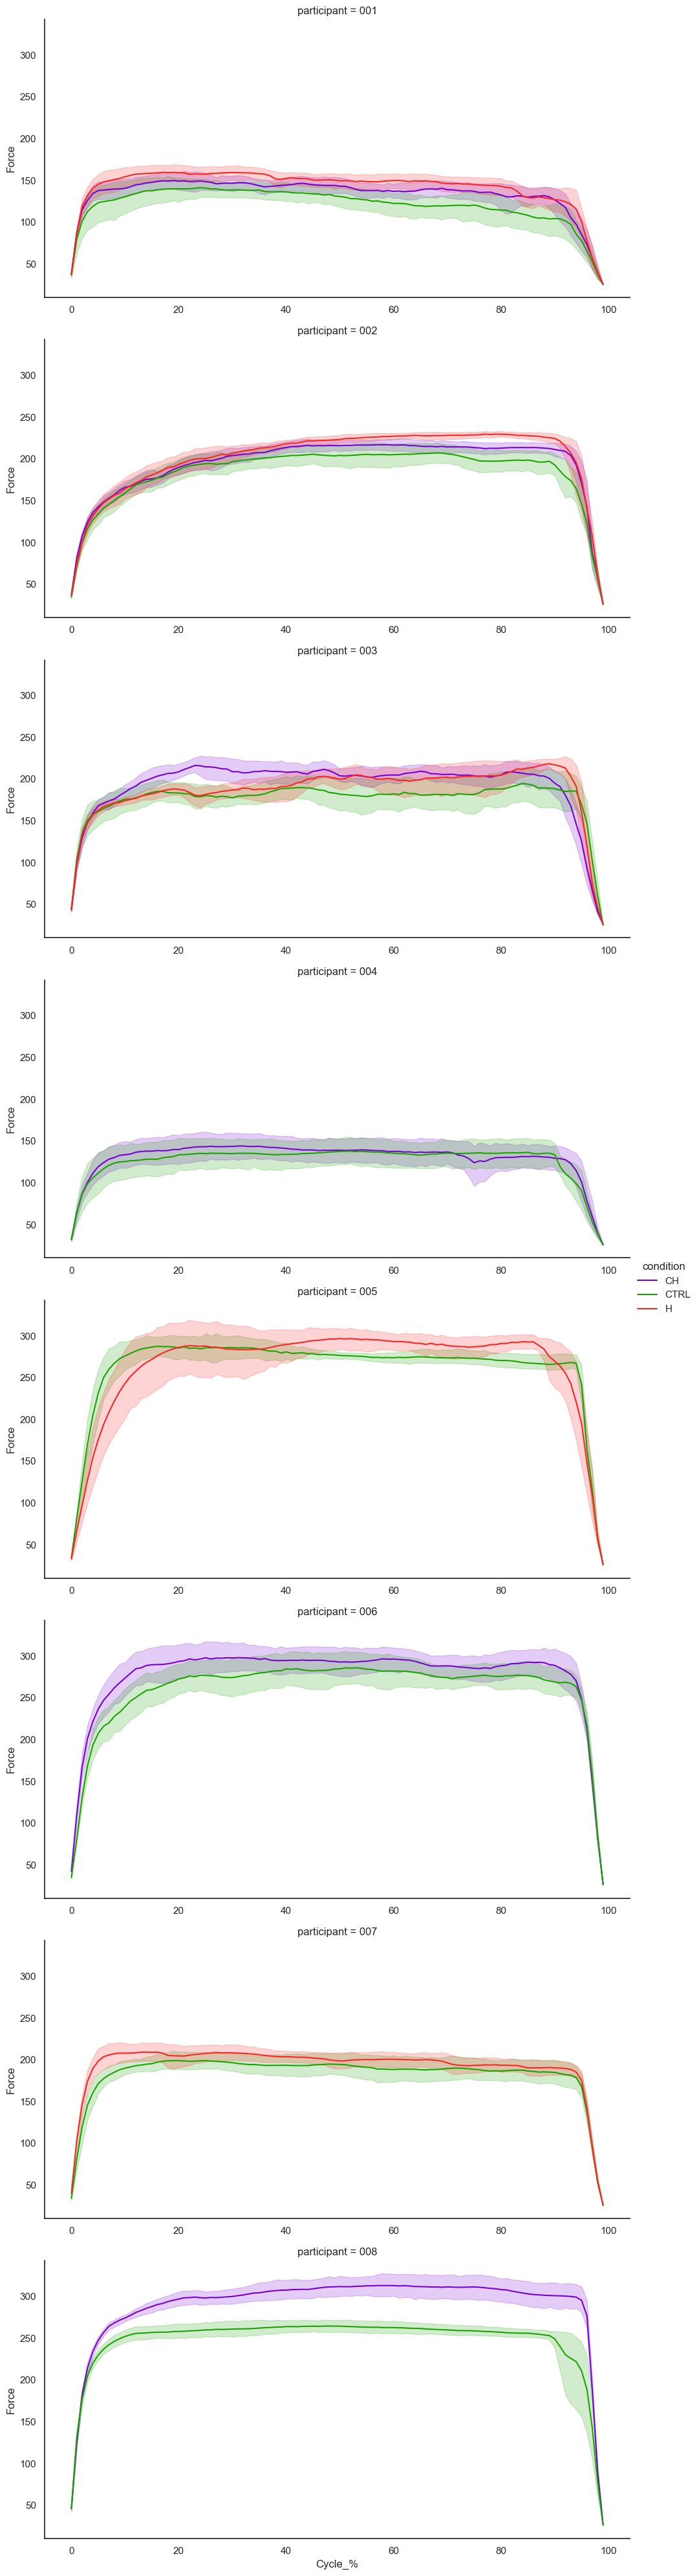

In [81]:
data_plot = df_flexion_interpol[
    (df_flexion_interpol['repetition'] != 0)
    & (df_flexion_interpol['mouvement'] == 'Flexion')
]

palette_colors = {'CTRL': '#1BA400', 'H': '#FC2424', 'CH': '#7700D4'}

sns.relplot(data_plot, 
             x= 'Cycle_%',
             y = 'Force',
             hue= 'condition',
             kind = 'line',
             aspect= 2,
             row = 'participant',
             palette=palette_colors,
             facet_kws=dict(sharex=False)
             )